In [2]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from simple_pid import PID

## Thrust Data

In [3]:
thrustFromFile = np.genfromtxt('./AeroTech_L1520T.csv',delimiter=',')

In [4]:
thrust = np.insert(thrustFromFile,0,[0,0],axis=0)

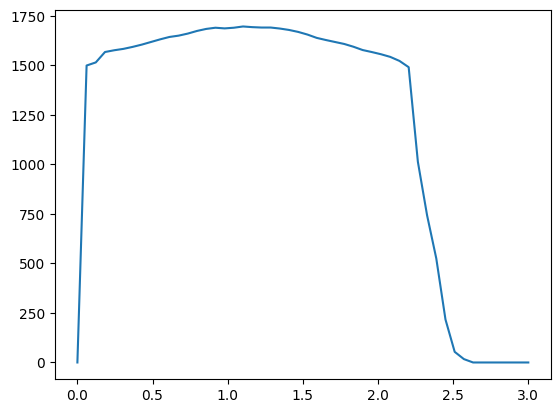

In [5]:
plt.plot(np.linspace(0,3),np.interp(np.linspace(0,3),thrust[:,0],thrust[:,1]));

In [6]:
#returns thrust force given a certain time in Newtons (N)
def thrustFunc(t):
    return 1.00*np.interp(t,thrust[:,0],thrust[:,1])

#returns an approximation for the density of air at a given altitutde
def rho(altitude):
    rho0 = 1.225 #kg/m^3
    Hn = 10.4*10**3 #meters
    return rho0*np.exp(-altitude/Hn)

## Simulation settings

In [35]:
dt=0.001
tInitial = 0
tFinal = 100
time = np.arange(tInitial,tFinal,dt)
local_dpi=150

In [8]:
mass = 20 #kg
gravityForce = np.array([0,0,-9.81])*mass
Area = 0.0232
parachuteDragCoefficient = 10

In [9]:
#given the rockets position, velocity, drag Coefficient, and time, return how the velocity and position change
def derivative(position, velocity,dragCoefficient, t):
    #determine which way the rocket is pointing
    direction = velocity/(np.linalg.norm(velocity)+10**-9)
    
    #if on rail, launch angle is set
    if(position[2]<1):
        direction = np.array([0,np.sin(0.0873),np.cos(0.0873)])
    
    #wind force - random gusts of wind pushing the rocket on the way up
    #wind mostly blows side to side and not up and down (I think?)
    windforce = windFunc(t)*np.array([rand.normal(loc=1,scale=windxStdDev),rand.normal(loc=1,scale=windyStdDev),rand.normal(loc=windzRatio,scale=windzStdDev)])
    
    sumForces = gravityForce + (thrustFunc(t) - 1/2*Area*rho(position[2])*np.linalg.norm(velocity)**2*dragCoefficient)*direction+windforce
    
    return [sumForces/mass,velocity + sumForces/mass*dt]
    
#function to perform integration step
#helpful to change out integration under the hood without needing to clutter main loop
def quadrature(position,velocity,dragCoefficient, t):
    
    #Heun's method
#     motion = derivative(position, velocity, dragCoefficient,t)
#     velocityGuess = velocity + motion[0]*dt
#     positionGuess = position + motion[1]*dt
    
#     motionUpdate = derivative(positionGuess,velocityGuess,dragCoefficient,t+dt)
    
#     velocityNext = velocity + dt/2*(motion[0]+motionUpdate[0])
#     positionNext = position + dt/2*(motion[1]+motionUpdate[1]) 
#     accelerationCurrent = 1/2*(motion[0]+motionUpdate[0])

    #Runge-Kutta method
    k1 = derivative(position, velocity, dragCoefficient,t)
    k2 = derivative(position + dt*k1[1]/2,velocity + dt*k1[0]/2,dragCoefficient,t+dt/2)
    k3 = derivative(position + dt*k2[1]/2,velocity + dt*k2[0]/2,dragCoefficient,t+dt/2)
    k4 = derivative(position + dt*k3[1],velocity + dt*k3[0],dragCoefficient,t+dt)
    
    velocityNext = velocity + dt/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0])
    positionNext = position + dt/6*(k1[1]+2*k2[1]+2*k3[1]+k4[1])
    accelerationCurrent = 1/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0])
    
    return positionNext, velocityNext, accelerationCurrent

## VLT

In [10]:
initialVel = 175
targetAlt = 1100
def velocityProfile(alt):
    return initialVel/np.sqrt(targetAlt)*np.sqrt(targetAlt-alt)

altitudes = np.linspace(0,targetAlt,100)

velocityLookupTableBase = np.array([altitudes,velocityProfile(altitudes)])
velocityLookupTable = np.transpose(np.genfromtxt('./DragVLT.csv',delimiter=','))

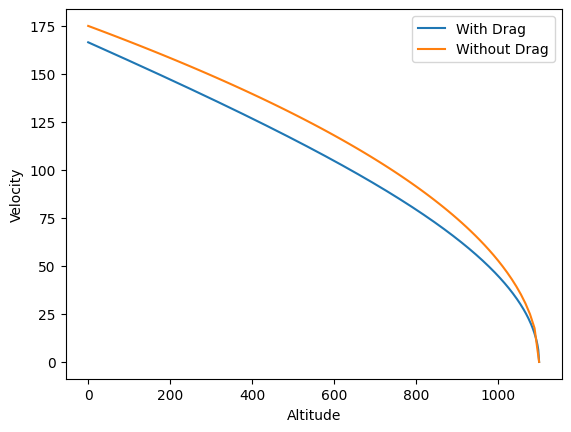

In [11]:
plt.plot(velocityLookupTable[0],velocityLookupTable[1]);
plt.plot(velocityLookupTableBase[0],velocityLookupTableBase[1]);
plt.legend(['With Drag','Without Drag']);
plt.xlabel('Altitude');
plt.ylabel('Velocity');

## Wind Settings

In [12]:
#function that kinda simulates random winds on the way up
def windFunc(time):
    return 3*(np.sin(time/2)+np.cos(time/20))

windxStdDev = .5
windyStdDev = .5
windzStdDev = .5
#ratio of z wind to xy wind
windzRatio = .5

## Controller Settings

In [13]:
controlFrequency= 8 #Hz
controldt = 1/controlFrequency
controlTicks = int(controldt//dt) #in number of ticks (if dt = 0.001, then this represents ms)
airbrakesMaxDrag = .2

def errorDecayFunc(alt):
    errorDecayTable = np.array([[targetAlt/2,7/8*targetAlt, 2*targetAlt],
                                [    6      ,    1.5,           0]])
    #find the index of the first altitude entry which is greater than the current altitude
    index = np.argmax((errorDecayTable[0]-alt)>0)
    return errorDecayTable[1,index]

def getMaxError(alt):
    maxErrorTable = np.array([[2/8*targetAlt,5/8*targetAlt, 2*targetAlt],
                                [    30      ,    15,           5]])
    #find the index of the first altitude entry which is greater than the current altitude
    index = np.argmax((maxErrorTable[0]-alt)>0)
    return maxErrorTable[1,index]

def calculateError(position,velocity):
    altitude = position[2]
    velocityError = velocity[2] - np.interp(altitude, velocityLookupTable[0],velocityLookupTable[1])
    if(velocityError < 0):
        velocityError = 0
    return velocityError

def findVLTVelocity(position):
    return np.interp(position[2], velocityLookupTable[0],velocityLookupTable[1])

## Kalman Filter settings

In [14]:
#kalman step size
sampleFrequency = 100 #Hz
kdt = 1/sampleFrequency
#for loop
kalmanTicks = int(kdt//dt)

#state Vector
#X = [[x],[y],[z],[vx],[vy],[vz],[ax],[ay],[az]]

#state transition matrix
Fkalman = np.array([[1,0,0,kdt,  0,  0,1/2*kdt**2,         0,         0],
                    [0,1,0,  0,kdt,  0,         0,1/2*kdt**2,         0],
                    [0,0,1,  0,  0,kdt,         0,         0,1/2*kdt**2],
                    [0,0,0,  1,  0,  0,       kdt,         0,         0],
                    [0,0,0,  0,  1,  0,         0,       kdt,         0],
                    [0,0,0,  0,  0,  1,         0,         0,       kdt],
                    [0,0,0,  0,  0,  0,         1,         0,         0],
                    [0,0,0,  0,  0,  0,         0,         1,         0],
                    [0,0,0,  0,  0,  0,         0,         0,         1]])

#Input translation matrix
#take input accelerations from rocket thrust and turn that into state matrix adjustment
Gkalman = np.array([[1/2*kdt**2,0,0],
                    [0,1/2*kdt**2,0],
                    [0,0,1/2*kdt**2],
                    [kdt,0,0],
                    [0,kdt,0],
                    [0,0,kdt],
                    [1,0,0],
                    [0,1,0],
                    [0,0,1]])

#observation model
#converts state vector to equivalent oberservations 
#we get the altitude from the altimeter and the acceleration data from IMU
#add in knowledge about 1/r^2 as if we had an rf reciever on the rocket and we were broadcasting from a known location
dx=-100
dy=-100
dz=0
def HkalmanFunc(stateVector):
    x = stateVector[0]-dx
    y = stateVector[1]-dy
    z = stateVector[2]-dz
    
    #common calculation
    r22 = (x**2+y**2+z**2)**2
    
    Hkalman = np.array([[0,0,1,0,0,0,0,0,0],
                        [0,0,0,0,0,0,1,0,0],
                        [0,0,0,0,0,0,0,1,0],
                        [0,0,0,0,0,0,0,0,1],
                        [-2*x/r22,-2*y/r22,-2*z/r22,0,0,0,0,0,0]])
    
    return Hkalman


#estimate covariance
#should be zero to start because we know exactly where the rocket starts
#however, setting it to this makes the kalman algorithm slow to adjust to the rapid start in motion
Pkalman = np.zeros((9,9))

#process noise
processVar=(.5)**2
Qkalman = np.matmul(Gkalman,np.transpose(Gkalman))*processVar

#measurement covariance
altimeterVar = (.1)**2
accelXVar = (2)**2
accelYVar = (2)**2
accelZVar = (2)**2
rfVar = (.001)**2

#measurement covariance matrix
Rkalman = np.array([[altimeterVar,0,0,0,0],
                    [0,           accelXVar,0,0,0],
                    [0,           0,accelYVar,0,0],
                    [0,           0,0,accelZVar,0],
                    [0,           0,0,0,rfVar]])


#measurement drift settings
accelXdrift = 1*kdt #m/s
accelYdrift = 1*kdt #m/s
accelZdrift = 1*kdt #m/s

## Integration Loop

In [83]:
time = np.arange(tInitial,tFinal,dt)
positions = np.zeros((len(time),3)); # x,y,z
velocities = np.zeros((len(time),3)); # vx,vy,vz
accelerations = np.zeros((len(time),3)); #ax,ay,az
dragCoefficient  = np.full((len(time)),.4);
errorArray = np.full((len(time)),0);
stateVectors = np.zeros((len(time),9))
measurements = np.zeros((len(time),5))
outputs = []
ideals = []
controls = []
localVelocities = []
Pkalman = np.eye(9)
innovation = 0
innovationCov = 0

integralError = 0;
#used to turn off controller after apogee
runControl = True;

pid = PID(1, 0.1, 0.2)

#used to truncate data
finalTick = 0

for i in range(len(time)-1):
    
    #see quadrature equation for how integration occurs
    positions[i+1], velocities[i+1], accelerations[i]  = quadrature(positions[i],velocities[i],dragCoefficient[i],time[i]) 
    
    #ends simulation when rocket hits ground
    if (positions[i,2]<=0) and (time[i]>1):
        finalTick = i
        break
        
    #Kalman filter attempt
    if((i%kalmanTicks==0) and (i>0)):
        #takes the current altitude and x,y,z accelerations and adds defined noise to those values
        #these values become the measurement that is fed into the kalman filter
        #the first step of the kalman filter is to predict what the next state should be based on the previous
        #step and the state transition matrix (essentially just forward integration)
        #it then converts this into the measurement space with Hkalman and comapres this with actual measured values
        #this difference is called the innovation
        #the kalman filter then corrects its guess at the next state by calculating the optimal gain Kkalman
        #Kkalman is determined by comparing the estimate covariance (how confident it is in the current estimate) and 
        #the innovation covariance (how confident it is in the measurement)
        
        #take measurement
        
        
        measurements[i:i+kalmanTicks] = [positions[i,2]+rand.normal(0,np.sqrt(altimeterVar)),
                                         accelerations[i,0]+rand.normal(accelXdrift,np.sqrt(accelXVar)),
                                         accelerations[i,1]+rand.normal(accelYdrift,np.sqrt(accelYVar)),
                                         accelerations[i,2]+rand.normal(accelZdrift,np.sqrt(accelZVar)),
                                         ((positions[i,0]-dx)**2+(positions[i,1]-dy)**2+(positions[i,2]-dz)**2)**-1+rand.normal(0,np.sqrt(rfVar))]
        
        ###Predict Step        
        stateVectors[i:i+kalmanTicks] = np.matmul(Fkalman, stateVectors[i-kalmanTicks])
        #Potentially add step that increases Qkalman during motor burn, then decreases it
        Pkalman = np.matmul(Fkalman,np.matmul(Pkalman,np.transpose(Fkalman))) + Qkalman
        
        Hkalman = HkalmanFunc(stateVectors[i])
        
        ###Update Step
        innovation = measurements[i] - np.matmul(Hkalman,stateVectors[i])
        
        innovationCov = np.matmul(Hkalman,np.matmul(Pkalman,np.transpose(Hkalman)))+Rkalman
        
        #optimal Kalman Gain
        Kkalman = np.matmul(Pkalman,np.matmul(np.transpose(Hkalman),np.linalg.inv(innovationCov)))
        #print(np.linalg.norm(Kkalman))
        
        #update state estimate
        stateVectors[i:i+kalmanTicks] = stateVectors[i] + np.matmul(Kkalman,innovation)
        #update estimate covariance
        Pkalman = np.matmul((np.eye(9)-np.matmul(Kkalman,Hkalman)),Pkalman)
        
    #deploy parachute when rocket hits apogee
    if ((stateVectors[i,5]<=0) and (time[i]>1)) and runControl == True:
        runControl = False
        dragCoefficient[i:] = parachuteDragCoefficient
        
    #control algorithim, evaluate periodically (250 ticks or 250 m/s)
    if(i%controlTicks==0) and runControl:
        #control algorithm outline
        # - determine how off the rocket velocity is from VLT given altitude
        #     - clip this value so that it less than the max allowable
        # - add the current error to the integral error term
        #     - subtract error decay given altitude
        #     - integral error penalizes being wrong for long period of time
        #     - have decay so that it doesn't always blow up to inf + allows me to make controller more strict over time
        # - control parameter is determined by summing current error and integral error and dividing by max error
        #     - airbrakes are then deployed such that that percentage of the drag coefficient is deployed
        #     - TODO: create transfer function from control parameter to deployment percentage
        #         - assume to be linear initially
        
        if time[i] < 2.5:
            continue

        maxError = getMaxError(stateVectors[i,2])
        #calculate how off the velocity is from desired
        #position, velocity

        ideal = findVLTVelocity(stateVectors[i,0:3])
        pid.setpoint= ideal
        # pid.output_limits = [-maxError, maxError]

        # errorArray[i+controlTicks] = calculateError(stateVectors[i,0:3],stateVectors[i,3:6])
        
        output = pid(stateVectors[i,3:6][2])
        # control = (stateVectors[i,0:3][2] - output) / stateVectors[i,0:3][2]
        # control = stateVectors[i,0:3][2] / ideal
        position = stateVectors[i,0:3][2]
        vel = stateVectors[i,3:6][2]
        control = (-output / .250) + mass*9.81
        control = output / (-0.5*rho(position)*vel**2)
        outputs.append(output)
        ideals.append(ideal)
        controls.append(control)
        localVelocities.append(stateVectors[i,3:6][2])

        #clip error so that it is at most maxError
        # if errorArray[i]>maxError:
        #     errorArray[i+controlTicks] = maxError
        
        #add this error to integralError
        #This will take account of continually wrong velocities and give it a boost
        #errorDecay helps this term not just grow over time
        #effectively means it will help velocity get within errorDecay of desiredVelocity
        # integralError += errorArray[i] - errorDecayFunc(positions[i,2])
        
        #if within a close value of the target vel, set the integral error to zero so that we don't overshoot
        # if errorArray[i]<.1:
        #     integralError = 0
        
        # if integralError < 0:
        #     integralError = 0
        
        # errorDerivative = errorArray[i]-errorArray[i-controlTicks]
        
        #calculate how much control we want to exert as a function of the maximum
        # control = (errorArray[i]+integralError-0.2*errorDerivative)/maxError
        
        #if control is greater than 1, bring it down
        # if control >1:
        #     control = 1
        if control <0:
            control = 1
        
        #adjust the drag coefficient for the next section of the simulation
        dragCoefficient[i:i+controlTicks] = dragCoefficient[i:i+controlTicks]*control
        if dragCoefficient[i] > 0.6 :
            dragCoefficient[i:i+controlTicks] = 0.6
        
time = time[:finalTick]
measurements = measurements[:finalTick]
positions = positions[:finalTick]
velocities = velocities[:finalTick]
accelerations = accelerations[:finalTick]
stateVectors = stateVectors[:finalTick]
dragCoefficient = dragCoefficient[:finalTick]
outputs = outputs[:finalTick]

print(np.max(positions[:,2]))

1173.2117863845212


## Plots

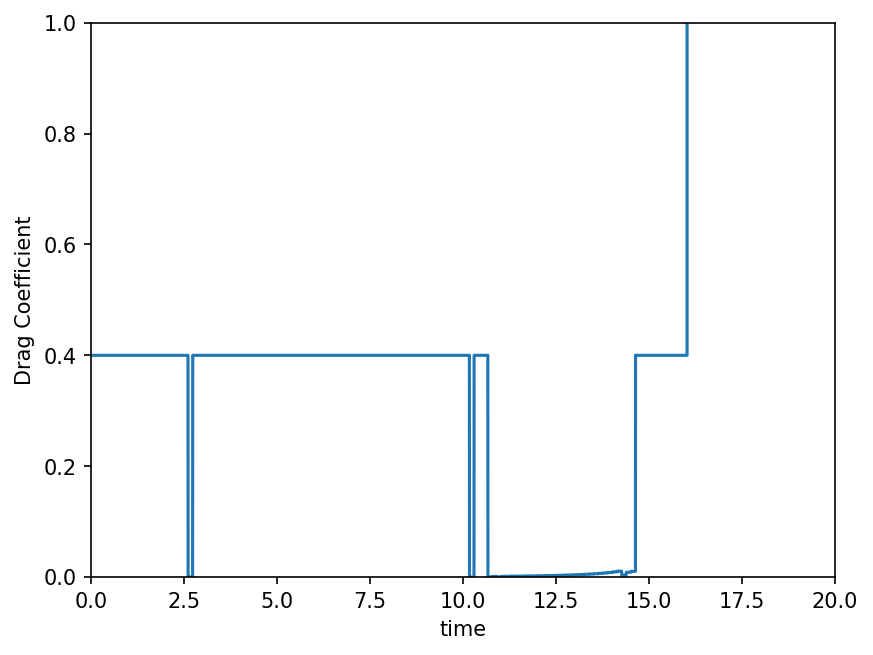

In [84]:
plt.figure(dpi=local_dpi)
plt.plot(time,dragCoefficient);
plt.ylim([0,1]);
plt.xlim([0,20]);
plt.xlabel('time')
plt.ylabel('Drag Coefficient');

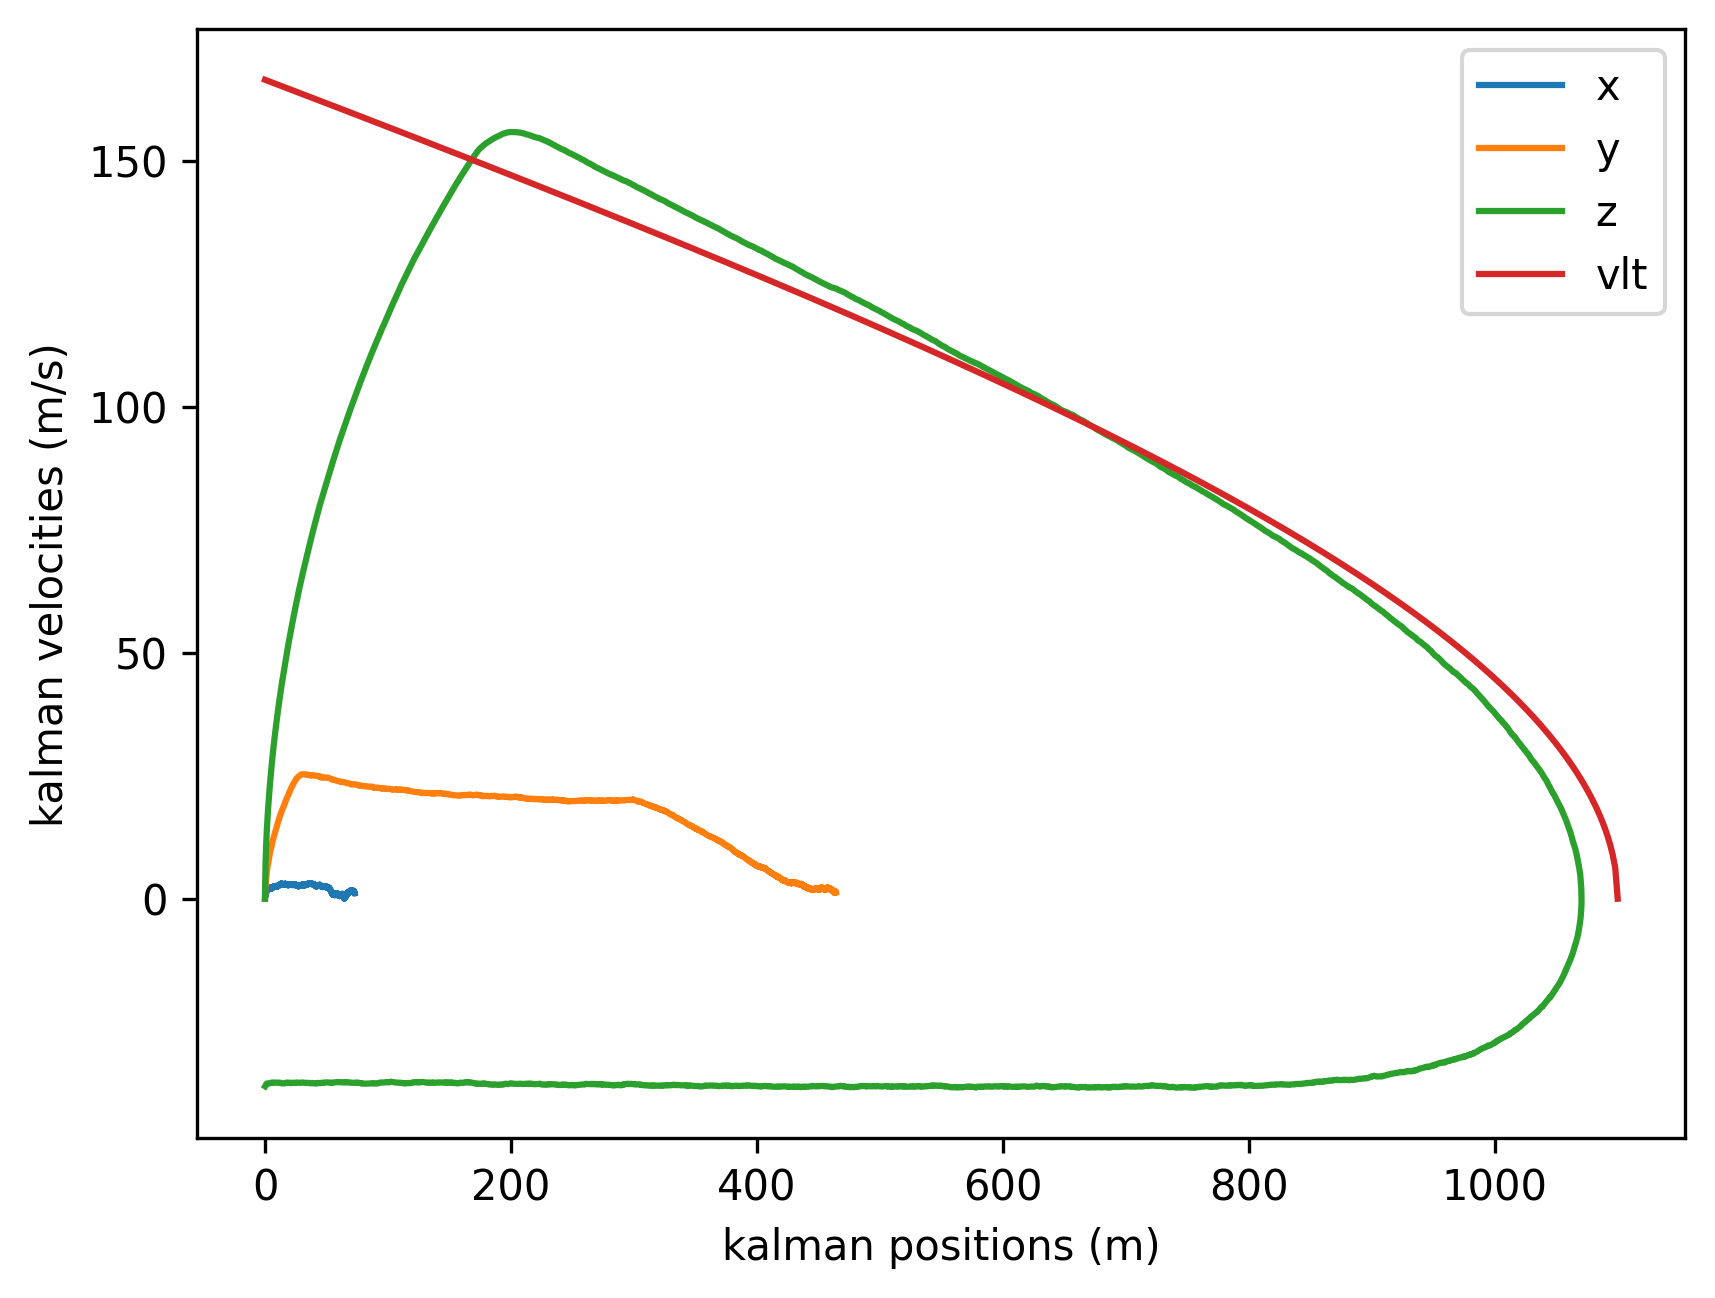

In [48]:
plt.figure(dpi=300)
plt.plot(stateVectors[:,0:3],stateVectors[:,3:6]);
plt.plot(velocityLookupTable[0],velocityLookupTable[1])
plt.xlabel('kalman positions (m)')
plt.ylabel('kalman velocities (m/s)')
plt.legend(['x','y','z','vlt']);

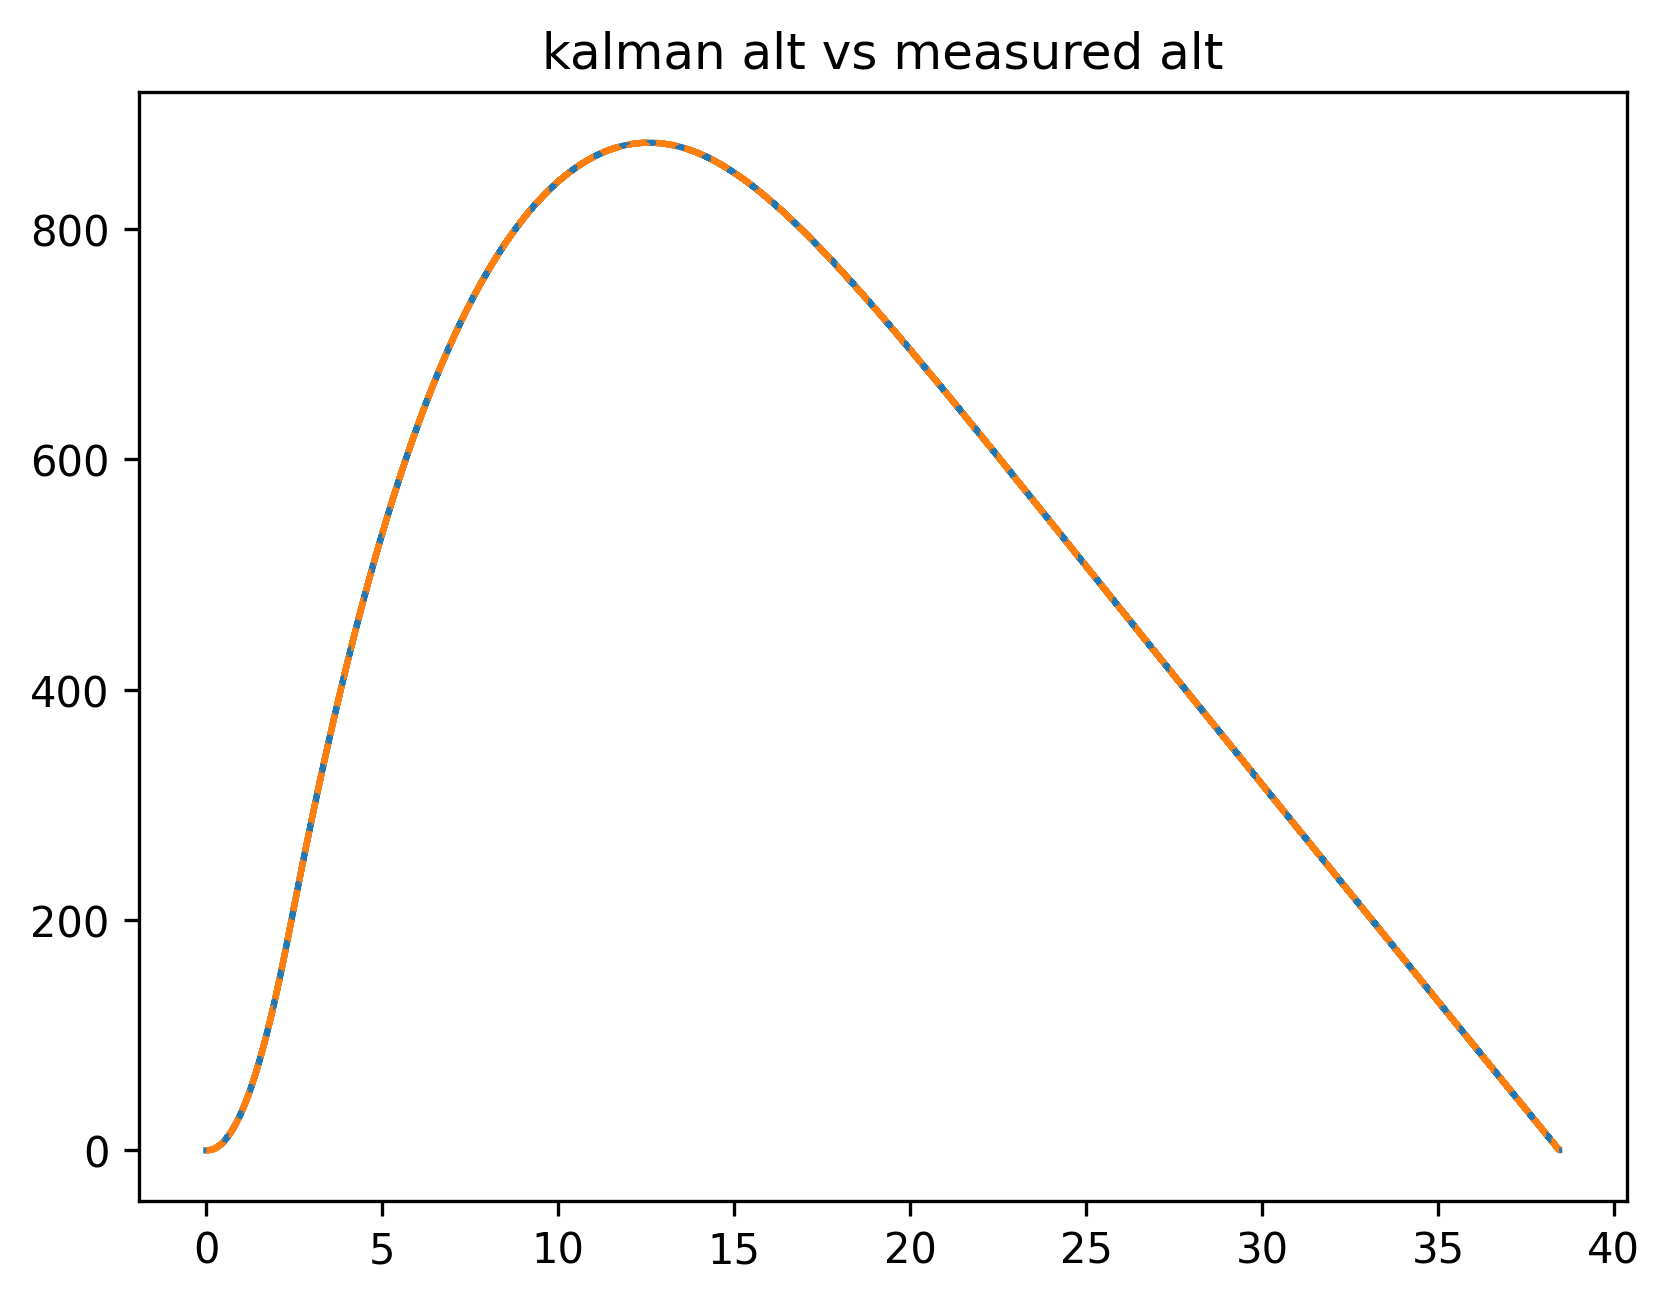

In [18]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,2])
plt.plot(time,measurements[:,0],'--');
plt.title('kalman alt vs measured alt');

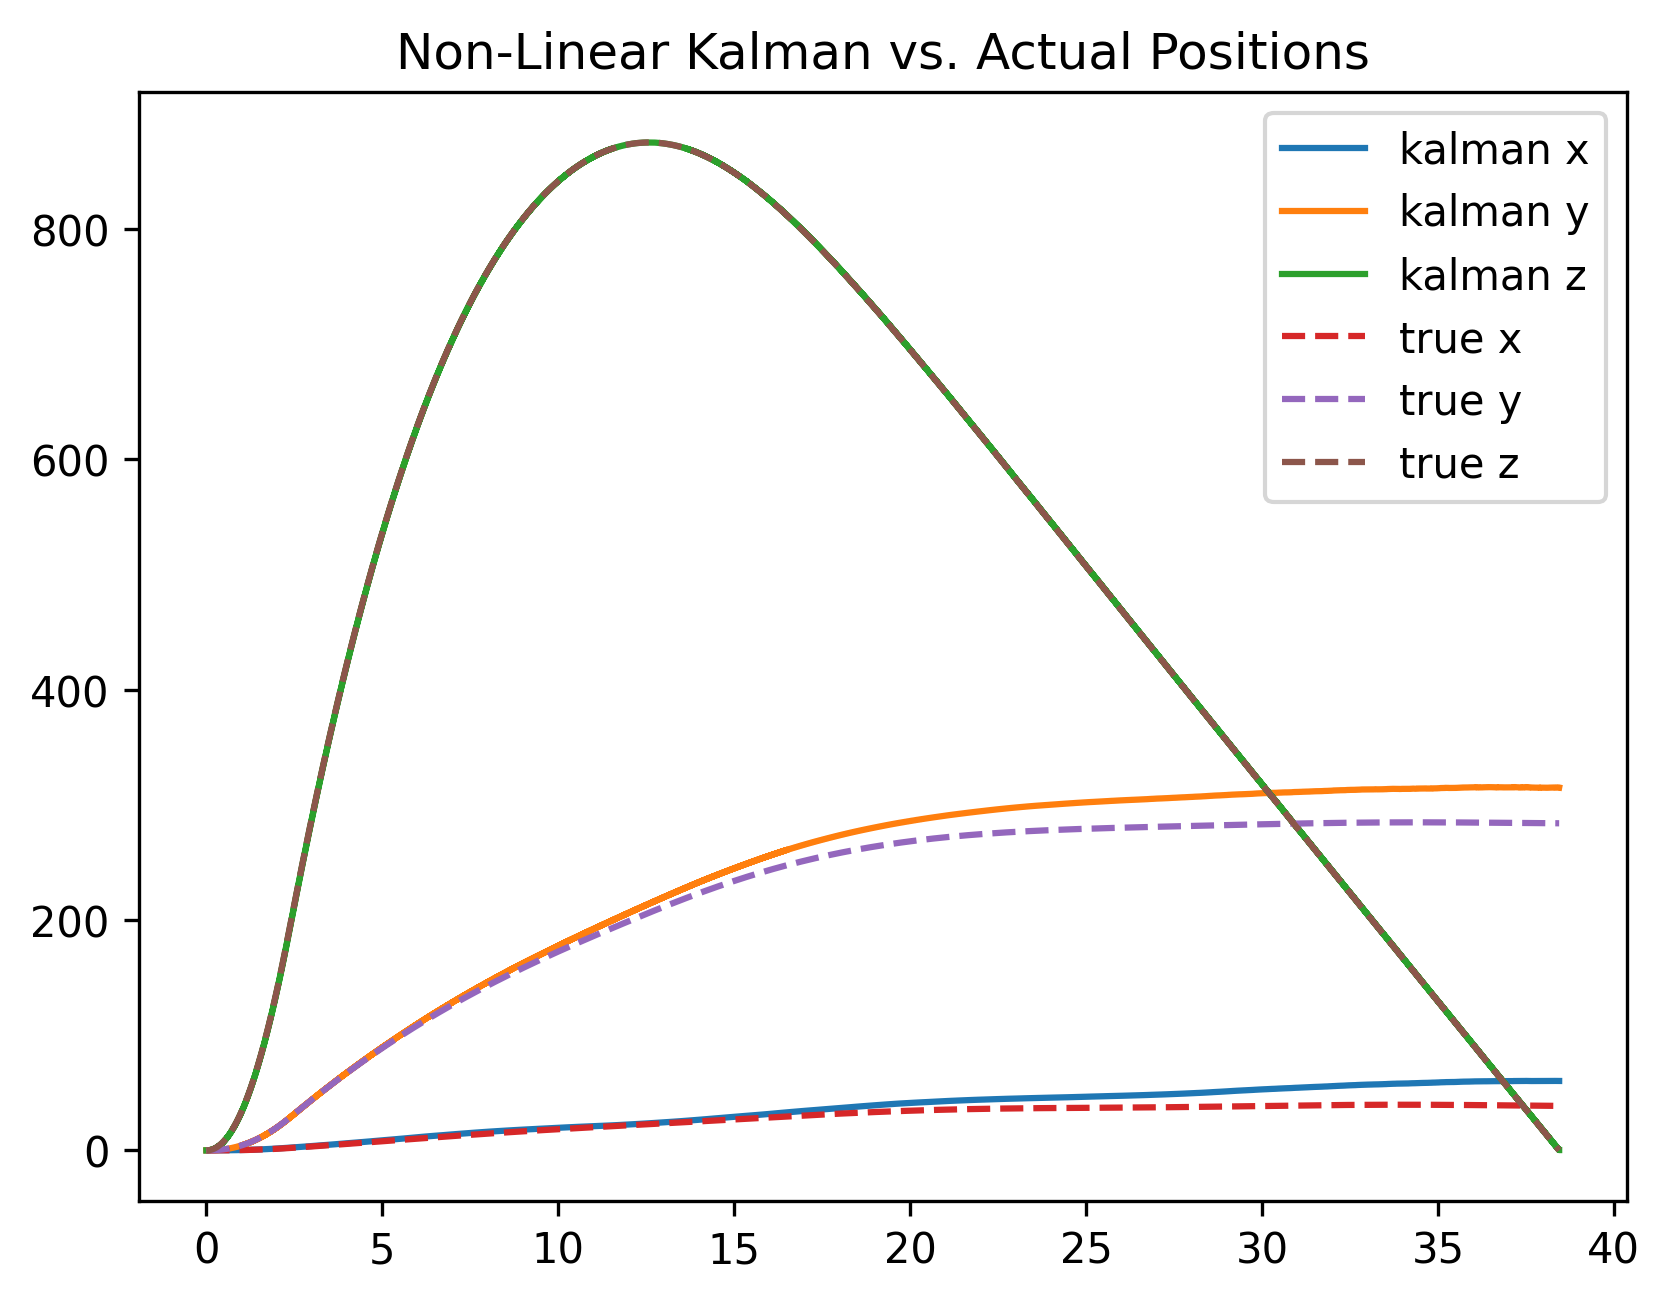

In [19]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,0:3]);
plt.plot(time,positions,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'])
plt.title('Non-Linear Kalman vs. Actual Positions');

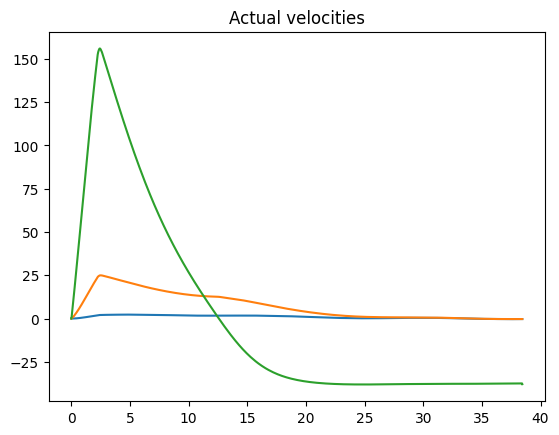

In [20]:
plt.plot(time,velocities);
plt.title('Actual velocities');

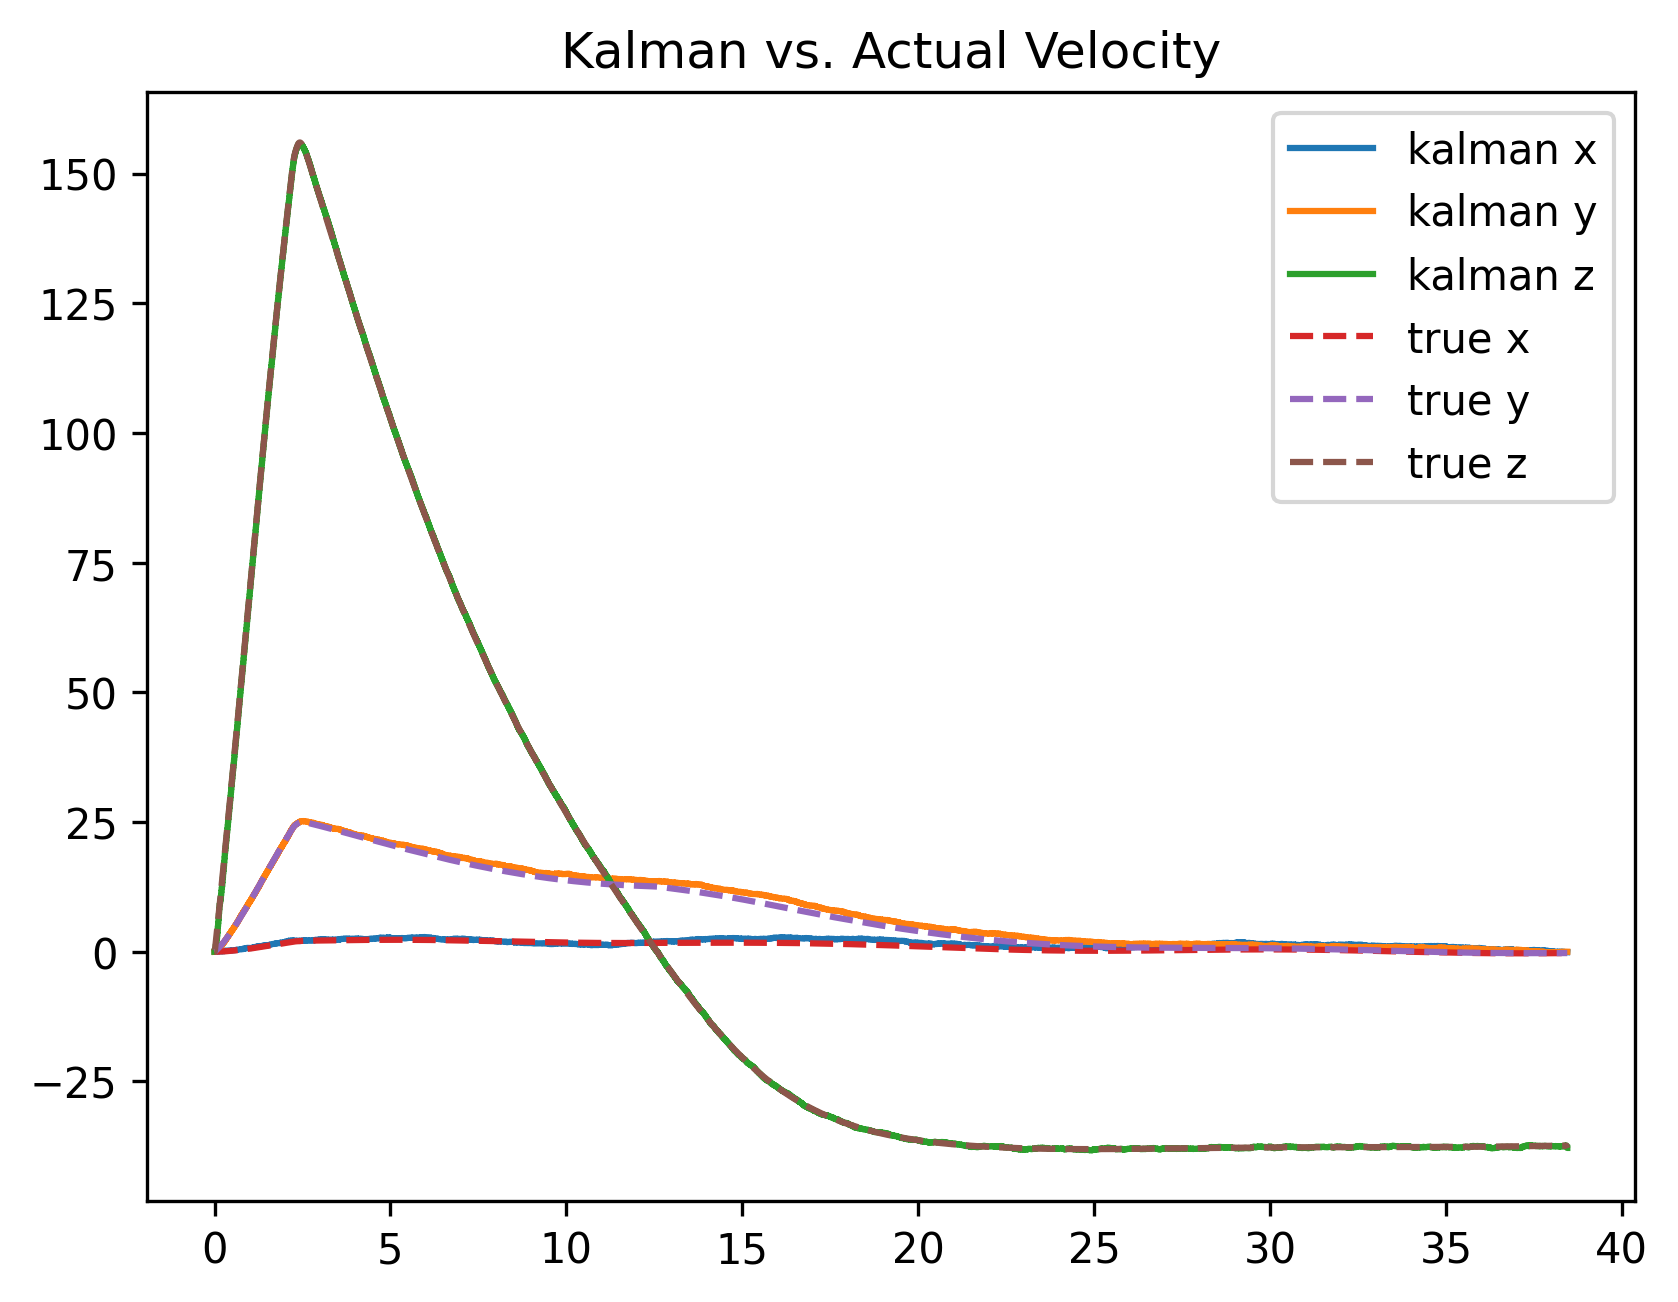

In [21]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,3:6]);
plt.plot(time,velocities,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'])
plt.title('Kalman vs. Actual Velocity');

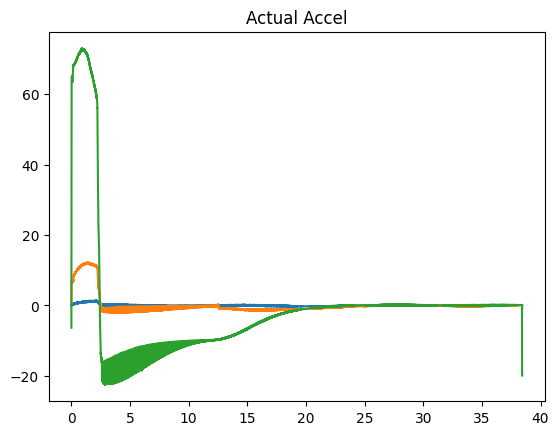

In [22]:
plt.plot(time,accelerations);
plt.title('Actual Accel');

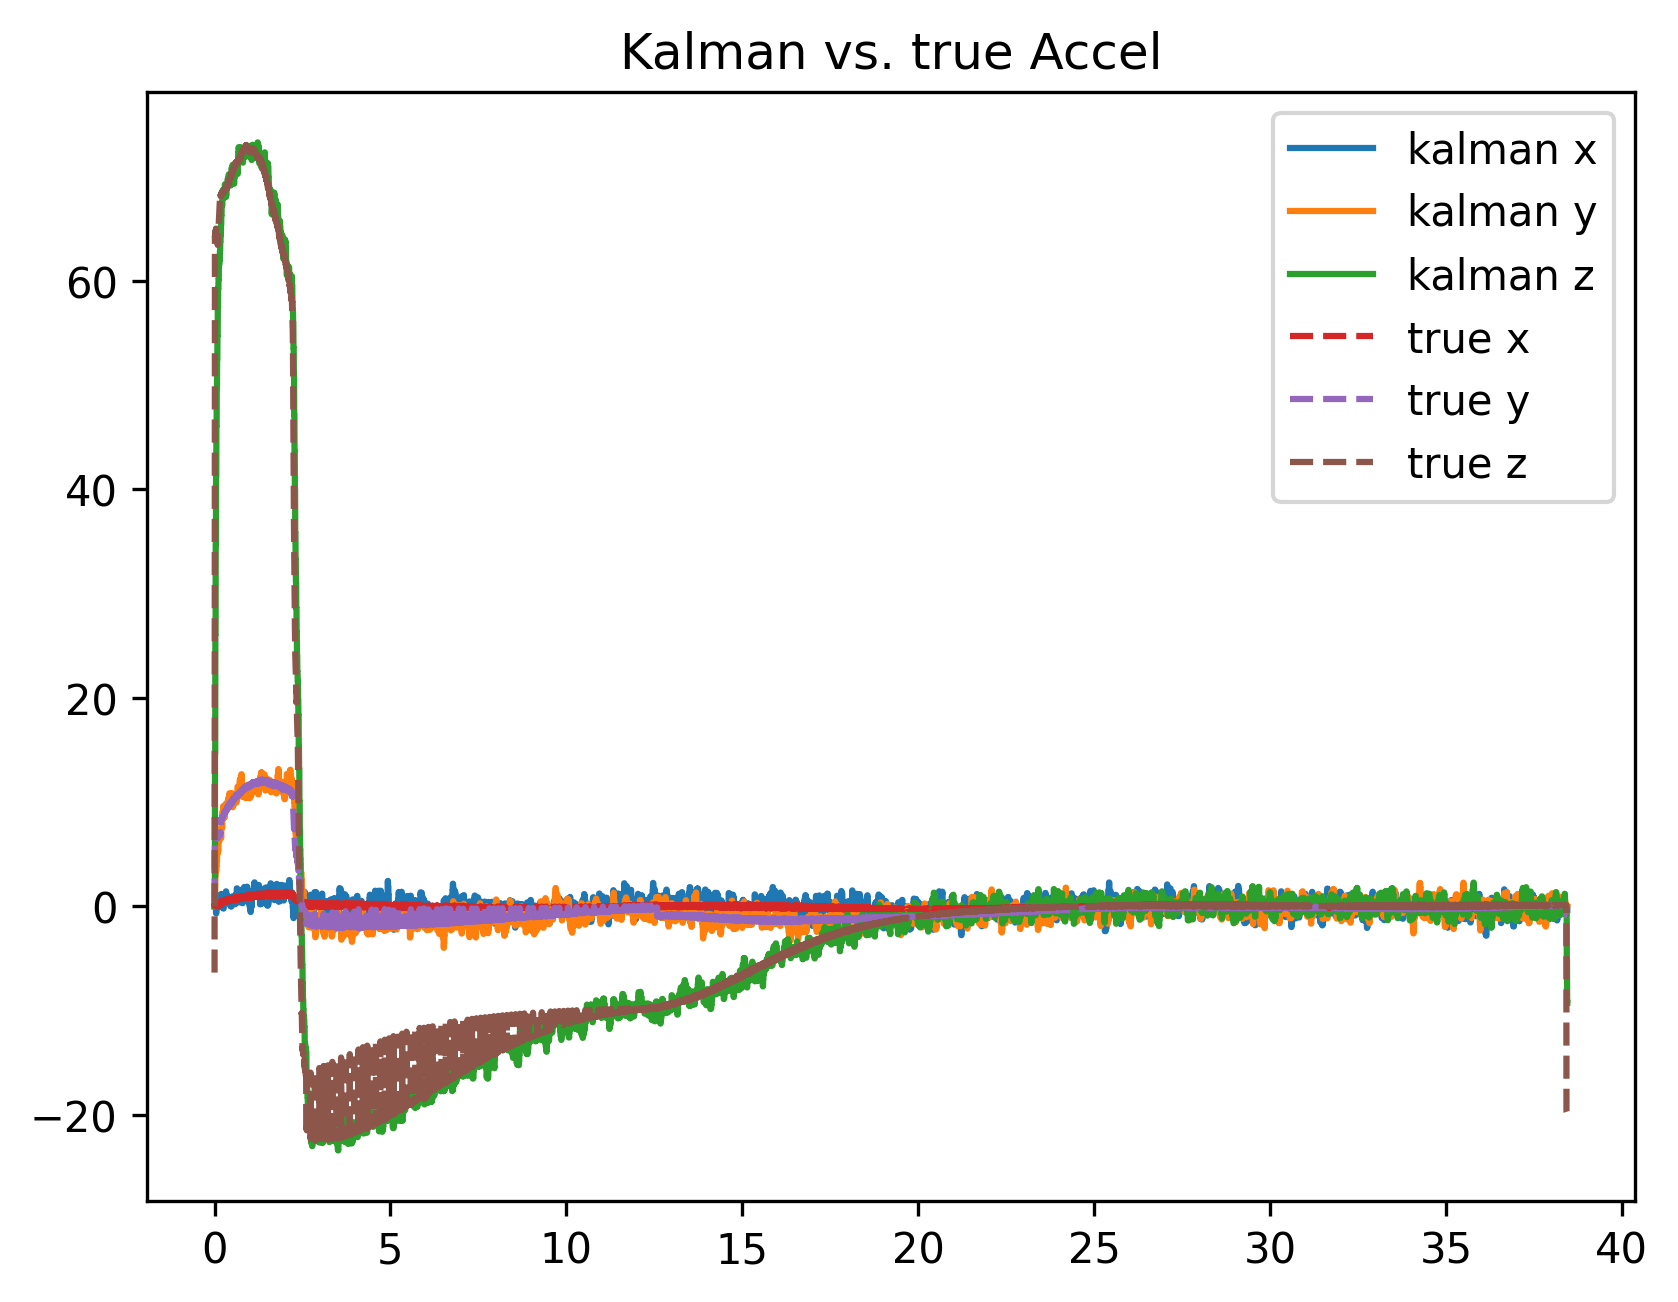

In [23]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,6:9]);
plt.plot(time, accelerations,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'])
plt.title('Kalman vs. true Accel');
#plt.xlim([0,10]);

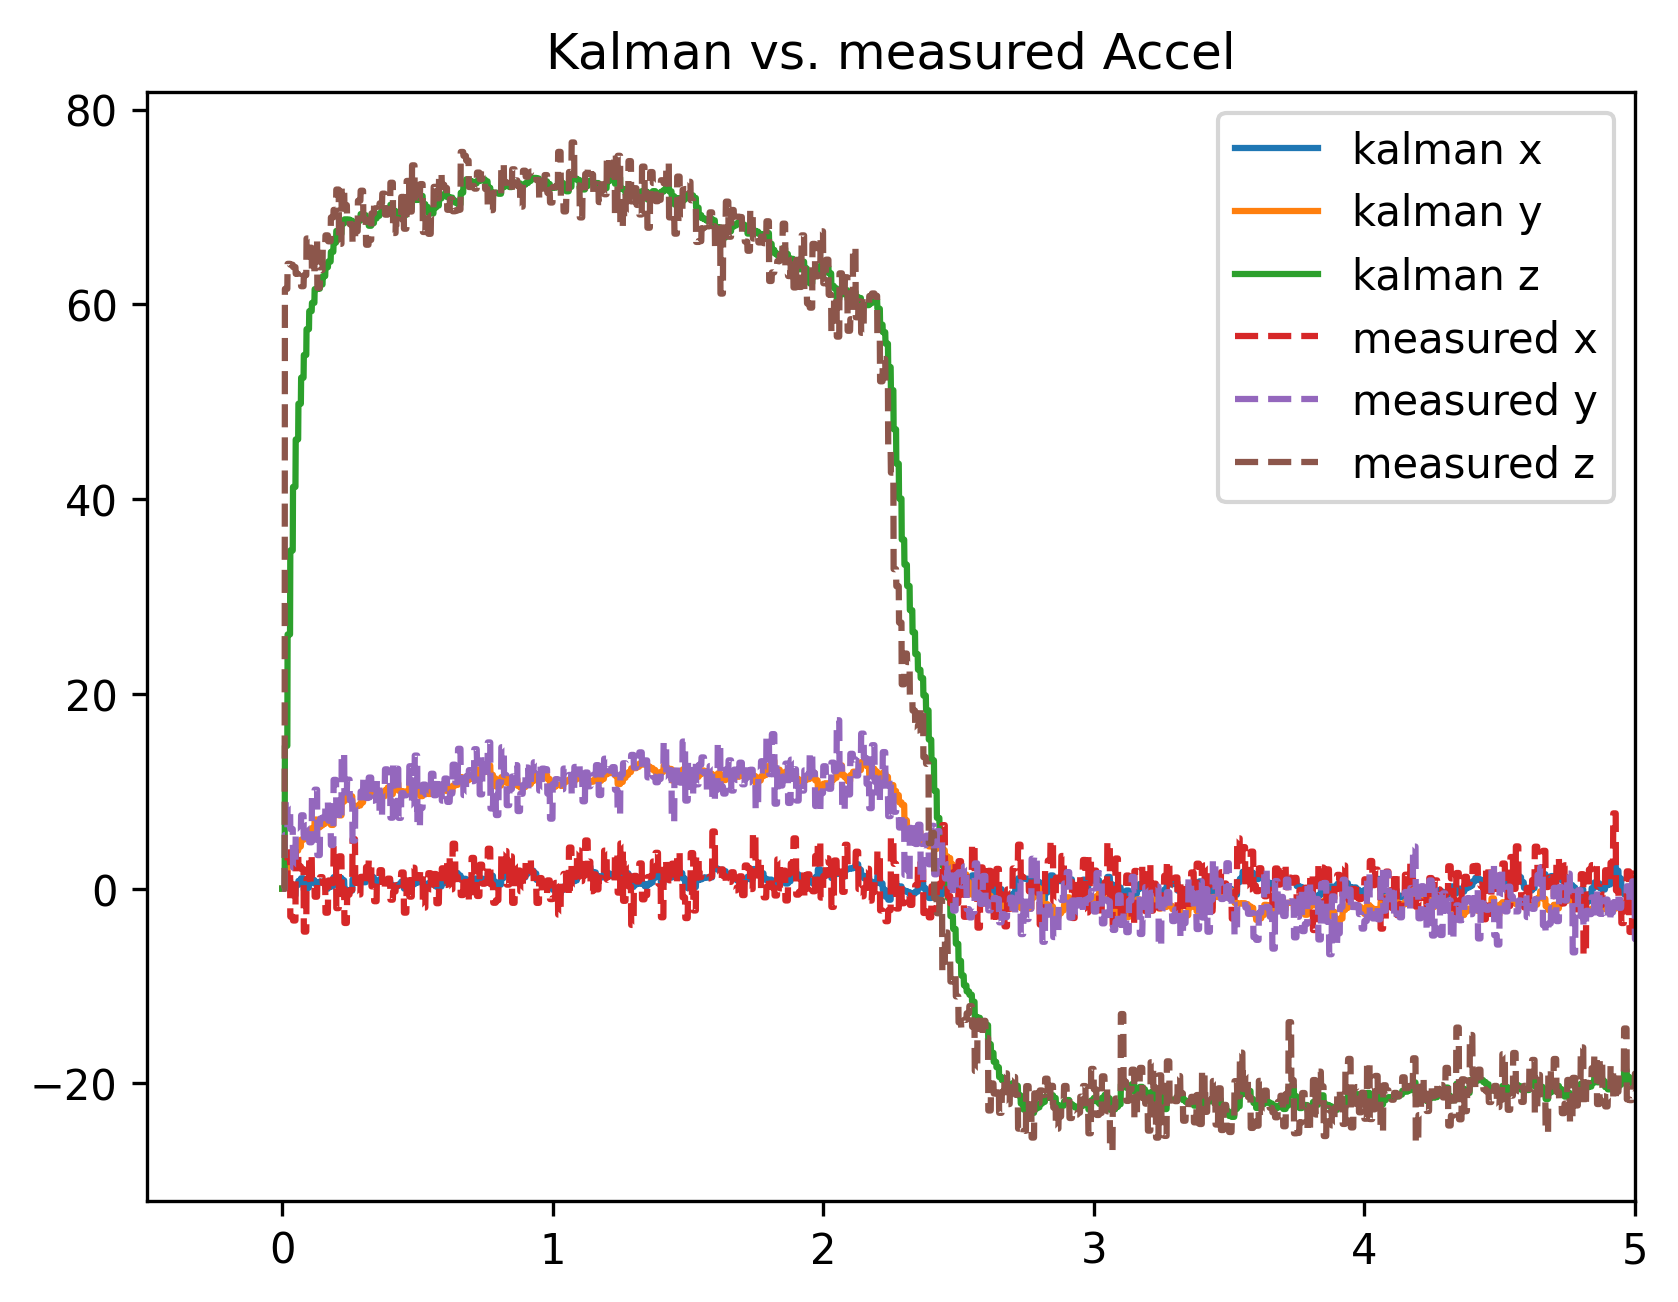

In [24]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,6:9]);
plt.plot(time, measurements[:,1:4],'--');
plt.legend(['kalman x','kalman y','kalman z','measured x','measured y','measured z'])
plt.title('Kalman vs. measured Accel');
plt.xlim([-.5,5]);

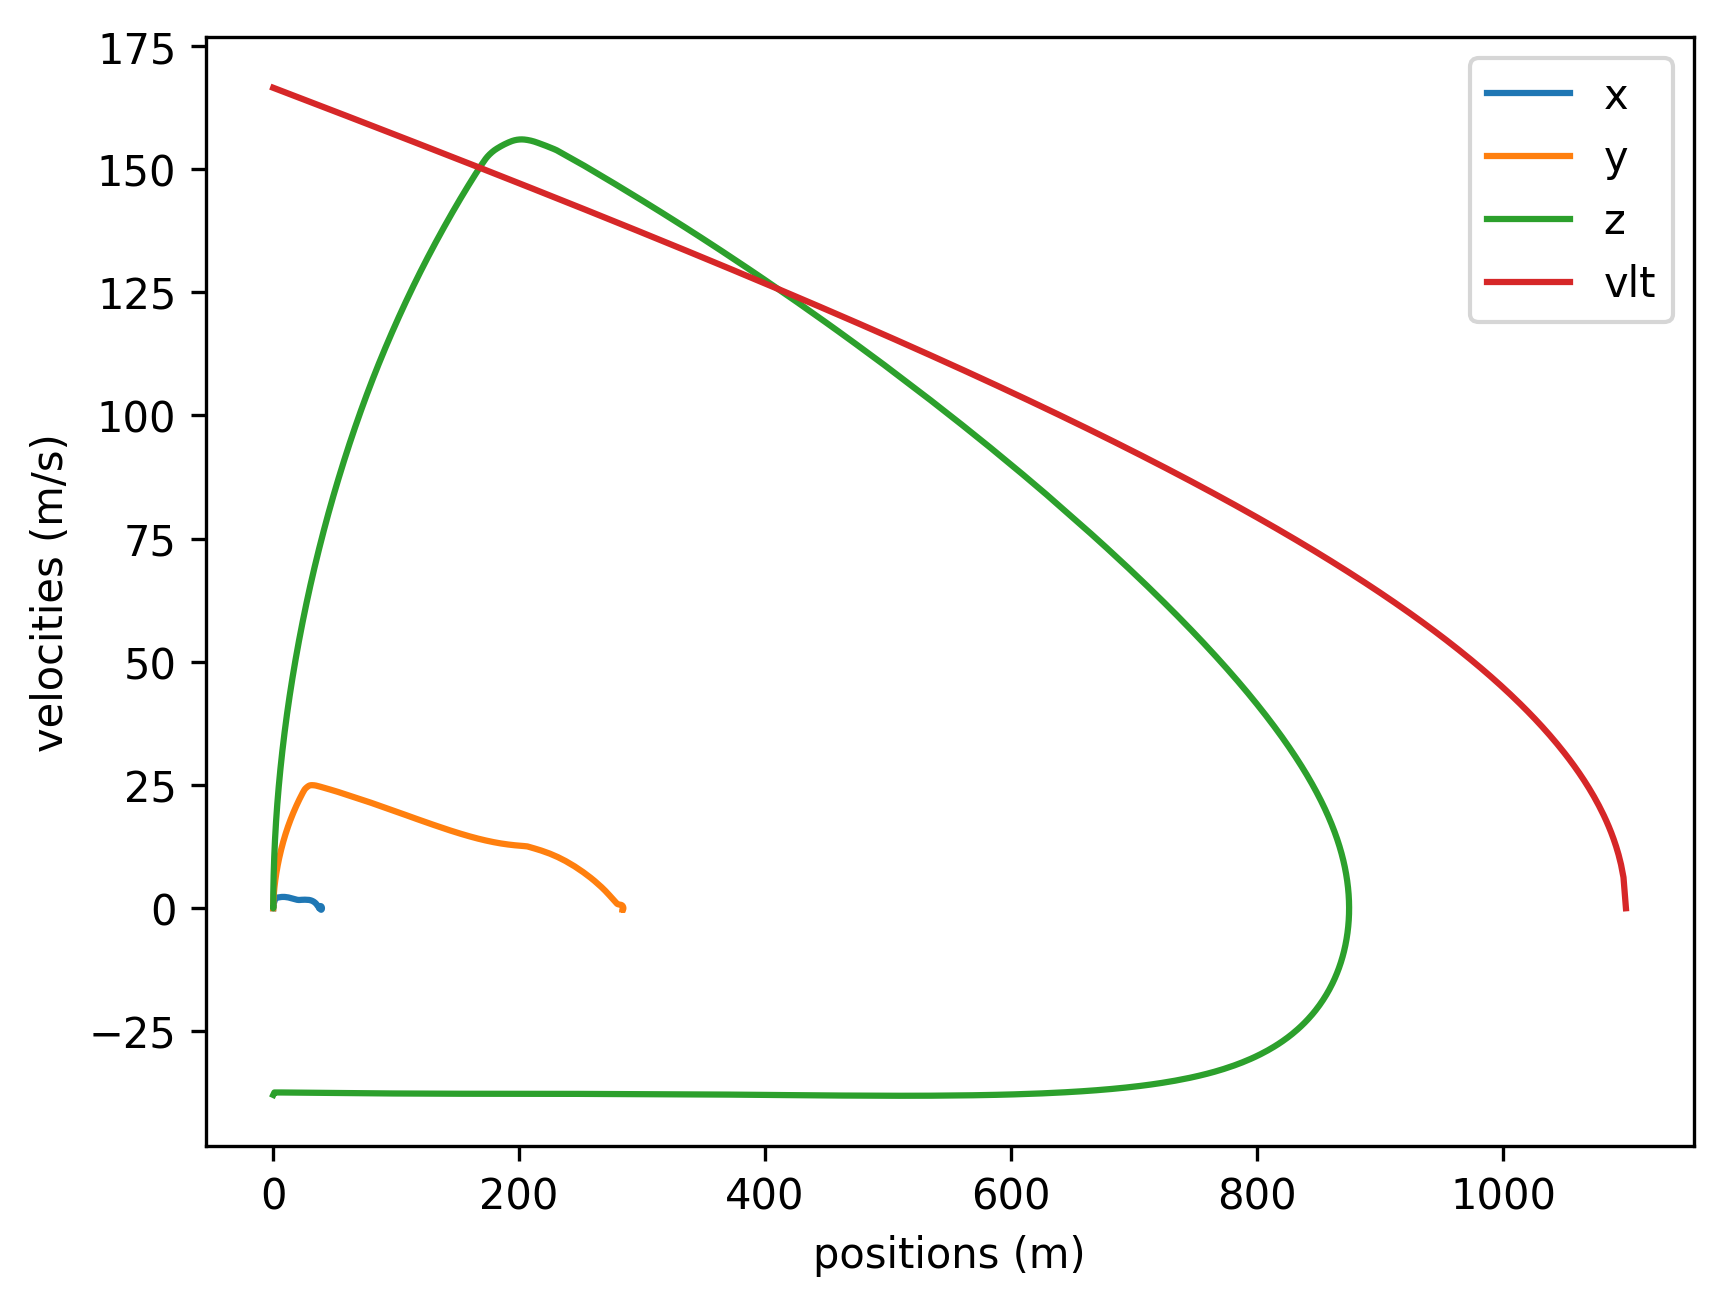

In [25]:
plt.figure(dpi=300)
plt.plot(positions,velocities);
plt.plot(velocityLookupTable[0],velocityLookupTable[1])
plt.xlabel('positions (m)')
plt.ylabel('velocities (m/s)')
plt.legend(['x','y','z','vlt']);

In [26]:
np.max(positions[:,2])

874.8809707229134

In [27]:
np.max(velocities[:,2])

155.98848252905847

In [28]:
positions[np.argmax(velocities[:,2]),2]

201.92732342994057

In [29]:
Pkalman

array([[ 2.23467513e+03, -4.33716939e-01, -4.47511174e-12,
         6.79584712e+01, -1.27446392e-02,  3.40794582e-10,
         1.61245046e-03, -2.83025968e-09,  1.25187569e-12],
       [-4.33716939e-01,  2.23378504e+03, -1.15075609e-11,
        -1.27446989e-02,  6.79320141e+01,  8.82675870e-10,
        -2.83034264e-09,  1.61244422e-03,  3.18897239e-12],
       [-4.47511174e-12, -1.15075609e-11,  6.09872525e-04,
        -1.42798482e-13, -3.67330450e-13,  1.93744382e-03,
        -2.31092759e-18, -5.98371235e-18,  1.21511757e-03],
       [ 6.79584712e+01, -1.27446989e-02, -1.42798482e-13,
         2.53669306e+00, -3.75259030e-04,  1.03189156e-11,
         4.00000000e-02, -8.60512057e-11,  4.19631125e-14],
       [-1.27446392e-02,  6.79320141e+01, -3.67330450e-13,
        -3.75259030e-04,  2.53590631e+00,  2.67264069e-11,
        -8.60532605e-11,  3.99999998e-02,  1.07066394e-13],
       [ 3.40794582e-10,  8.82675870e-10,  1.93744382e-03,
         1.03189156e-11,  2.67264069e-11,  1.235228

C:\Users\pjkir\AppData\Local\Temp\ipykernel_21548\3054167834.py:1: RuntimeWarning: invalid value encountered in sqrt
  logPkalman = np.sqrt(Pkalman);


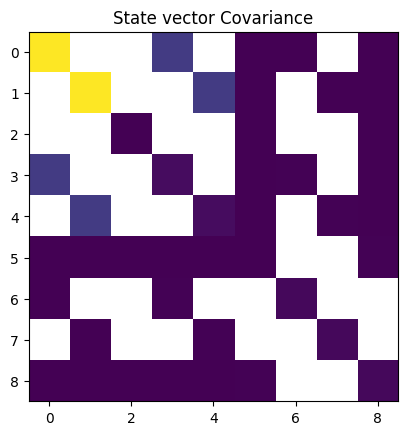

In [30]:
logPkalman = np.sqrt(Pkalman);
logPkalman[np.isneginf(logPkalman)] = 0
plt.imshow(logPkalman);
plt.title('State vector Covariance');